# 次元削除

## PCA
`PCA`(主成分分析)は群を抜いてよく使われる次元削除アルゴリズムである。

In [15]:
import numpy as np
import matplotlib.pyplot as plt

## 主成分
PCAは訓練セットの分散を最大限に維持する軸を見つける。訓練セットから主成分を見つけるにはどうすればいいのか。
訓練セット行列$X$を$U \cdot \sum \cdot V^t$の３行列のドット積に分解出来る`特異値分解`という行列分解テクニックがある

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [16]:
# 三次元のデータを作成する
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [17]:
X[0]

array([-1.01570027, -0.55091331, -0.26132626])

In [18]:
X_cesntered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_cesntered)

c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 低次のd次元への射影
全ての主成分が見つかったら、最初のd次元の成分が定義する平面に射影すれば、データセットをd次元に削減できる。  
訓練セットを平面に射影するには、訓練セット行列$X$と最初のd個の主成分によって定義される行列$W_d$のドット積を計算すれば良い。

In [19]:
w2 = Vt.T[:, :2]
X2D = X_cesntered.dot(w2)

In [20]:
X2D[:3]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729]])

### scikit-learnの使い方
scikit-learnを使用して次元を削減する

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [23]:
X2D[:3]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729]])

### 因子寄与率
`explained_varianced_variance_rate_`変数から得られる個々の主成分の因子寄与率も重要な情報である。

In [24]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

この値はデータセットの84.2%が第1軸に沿ったものであり、14.6%が第2軸にそったものだと表している。

### 適切な次数の選択
次数をいくつまで削減するかは、無作為に選ぶのではなく、各次元に沿った因子寄与率の合計が十分な割合になるような形を選ぶようにする。

In [25]:
from sklearn.datasets import fetch_mldata

In [26]:
mnist = fetch_mldata('MNIST original')

In [27]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [28]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [44]:
for i, c in enumerate(cumsum):
    if c > 0.95:
        print(i)
        break

153


95%の因子寄与率ならば153次元まで削減すれば良い

Text(0, 0.5, 'explained_variance_ratio_')

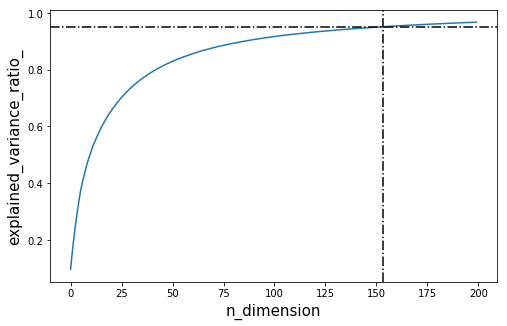

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(cumsum[:200])
plt.axhline(0.95, ls='-.', color='black')  
plt.axvline(153, ls='-.', color='black')

plt.xlabel('n_dimension', size=15)
plt.ylabel('explained_variance_ratio_', size=15)

### 圧縮のためのPCA
上のグラフから分散が95%維持されるようにPCAに適用するとオリジナルの784から150くらいに減ることがわかる。  
分散の大半を維持しつつも、サイズは元のサイズの20%ほどに圧縮されている。

PCAの射影を逆変換すれば次元を削除したデータセットを元の784次元に戻すことができる。

In [61]:
pca = PCA(n_components=153)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [62]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

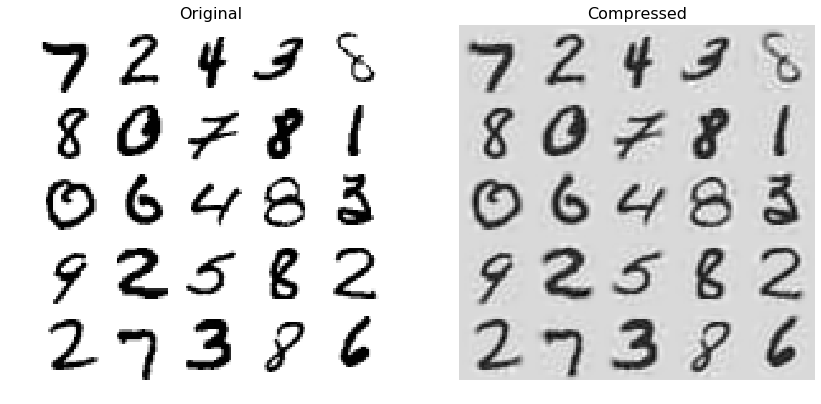

In [64]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

訓練セットよりも品質が落ちているが、数字はほとんど変わらずに認識することができる。

### 追加学習PCA
PCAの実装には、SVDアルゴリズムを実行するために訓練セット全体がメモリに収まっている必要がある。　`追加学習PCA`は、訓練セットをミニバッチに分割し、1度一つずつIPCAアルゴリズムを実行していく。大規模な訓練セットやPCAをオンライン実行したいときに役に立つ。

In [65]:
from sklearn.decomposition import IncrementalPCA

In [66]:
n_bathes = 100
inc_pca = IncrementalPCA(n_components=153)
for X_batch in np.array_split(X_train, n_bathes):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

### ランダム化PCA
scikit-learnには、PCAを実行するオプションとして`ランダム化PCA`がある。これは最初のd個の主成分の近似値を素早く見つけられる確率的なアルゴリズムである。  計算量は、$O(m　\times n^2) + O(n^3)$ではなく、$O(m \times d^2) + O(d^3)$になり、dがよりもかなり小さい時、大幅に高速になる

In [69]:
rnd_pca = PCA(n_components=153, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

### カーネルPCA
暗黙のうちにインスタンスを非常に高次な空間（`特徴量空間`）にマッピングして、SVMで非線形の分類や回帰を実現するカーネルトリックは５章でおこなった。 工事特徴量空間での線形の決定境界は`オリジナル空間`の複雑な非線形決定境界にも対応している。

PCAも同じトリックを利用して、PCAが次元を削除するための複雑な非線形射影を実現できる。これを`カーネルPCA`と呼ぶ

In [71]:
from sklearn.datasets import make_swiss_roll

In [72]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [73]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

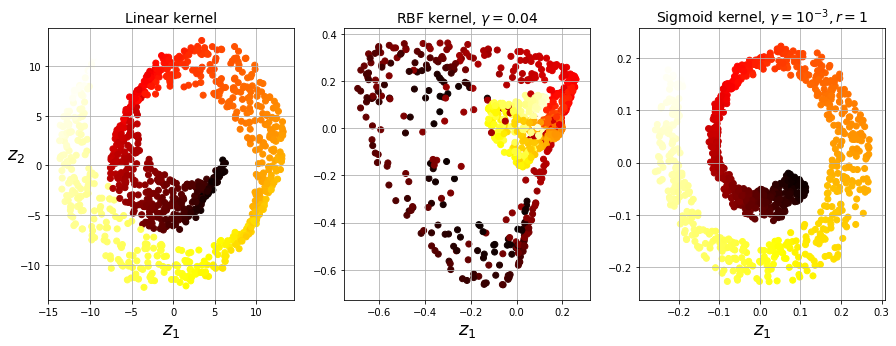

In [75]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(15, 5))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)